In [1]:
#LETS WORK WITH CIFAR 10 DATA 

#ABOUT CIFAR 10 

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

#How to get Images 

 we have  a package called torchvision, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader.

 

In [2]:
#STEP 1 : LOAD CIFAR 10 DATA
import os
os.path.abspath(os.getcwd())

'/content'

In [3]:
#SECTION1 REQUIRED LIBRARY 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

from drive.MyDrive.S8.utils import Dataloader
from drive.MyDrive.S8.utils import show_images
from drive.MyDrive.S8.utils import classcount
from drive.MyDrive.S8.models import BasicModel
from drive.MyDrive.S8.models import RESNET
from drive.MyDrive.S8.utils import plot_misclassified_image
from drive.MyDrive.S8.utils import perClassResult
from drive.MyDrive.S8.utils import train
from drive.MyDrive.S8.utils import test

In [4]:
#DOWNLOAD THE IMAGES 

class Args:

    # Data Loading
    # ============

    # train_batch_size = 64
    # val_batch_size = 64
    num_workers = 4
    batch_size = 128


    # Regularization
    # ==============
    #dropout = 0.1
    dropout = 0

    # Training
    # ========
    random_seed = 1
    epochs = 15
    learning_rate = 0.01
    momentum = 0.9


In [5]:
import torchvision
import torchvision.transforms as transforms
import torch
trainloader,testloader=Dataloader.train_test_loader(Args.batch_size,Args.num_workers)
classes = Dataloader.get_classes()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


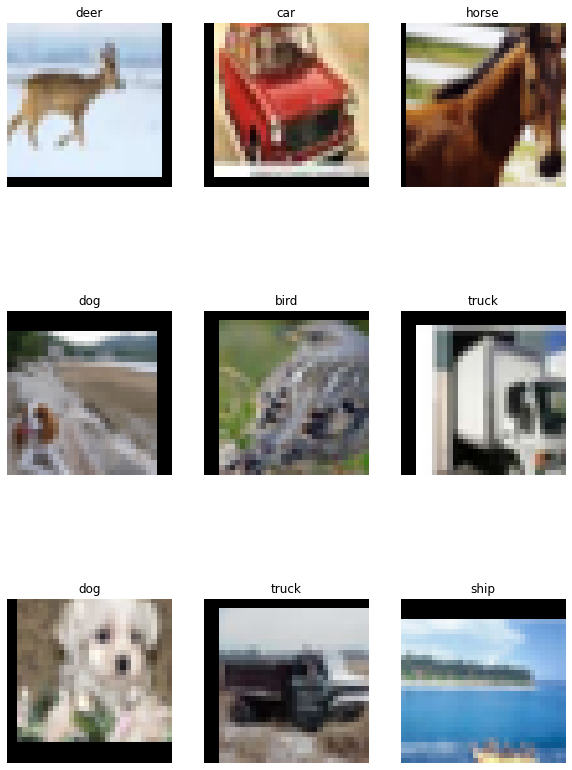

In [6]:
#plot  n raw images 
#make sure n is a squared number 
show_images.plot_n_image(9,trainloader,classes,format='raw')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


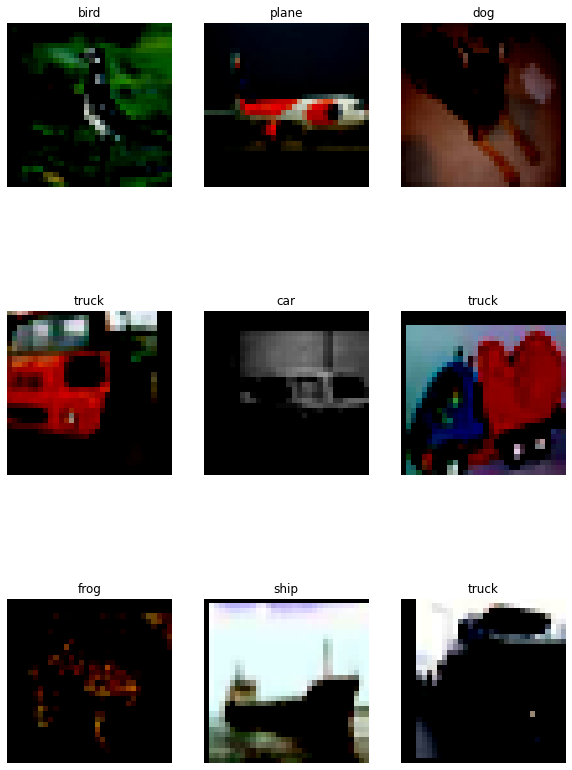

In [7]:
#plot  n normalized images 
#make sure n is a squared number 
show_images.plot_n_image(9,trainloader,classes,format='normalized')

In [8]:
class_count = classcount.get_train_class_count(classes)
print(class_count)

Files already downloaded and verified
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'car': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'plane': 5000}


In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

#working 
#model = BasicModel.Net().to(device)


model = RESNET.ResNet18().to(device) 
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [10]:

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
#criterion = nn.CrossEntropyLoss()
lossfunc = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

In [ ]:
#Test
EPOCHS = 50

trainer = train.Trainer()
tester  = test.Tester()

for epoch in range(EPOCHS):
  print("EPOCH:", epoch, "last LR=",scheduler.get_last_lr(), "LR = ", scheduler.get_lr())
  trainer.train(model, device, trainloader, optimizer, lossfunc, epoch, 5e-4)
  scheduler.step()
  tester.test(model, device, testloader)



test_losses,test_acc=tester.getValuesTest()
train_losses,train_acc=trainer.getValuesTrain()


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0 last LR= [0.01] LR =  [0.01]


Train set: Loss=7.753057479858398 Batch_id=390 Accuracy=42.66: 100%|██████████| 391/391 [01:00<00:00,  6.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.7164, Test Accuracy: 4610/10000 (46.10%)

EPOCH: 1 last LR= [0.01] LR =  [0.01]


Train set: Loss=5.121778964996338 Batch_id=390 Accuracy=50.13: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -2.9328, Test Accuracy: 4792/10000 (47.92%)

EPOCH: 2 last LR= [0.01] LR =  [0.01]


Train set: Loss=4.587494850158691 Batch_id=390 Accuracy=54.37: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -3.5389, Test Accuracy: 4654/10000 (46.54%)

EPOCH: 3 last LR= [0.01] LR =  [0.01]


Train set: Loss=4.329016208648682 Batch_id=390 Accuracy=57.74: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.3283, Test Accuracy: 4773/10000 (47.73%)

EPOCH: 4 last LR= [0.01] LR =  [0.01]


Train set: Loss=4.395341396331787 Batch_id=390 Accuracy=59.94: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.3067, Test Accuracy: 4161/10000 (41.61%)

EPOCH: 5 last LR= [0.01] LR =  [0.01]


Train set: Loss=3.686035633087158 Batch_id=390 Accuracy=62.74: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -4.8964, Test Accuracy: 4675/10000 (46.75%)

EPOCH: 6 last LR= [0.001] LR =  [0.0001]


Train set: Loss=3.214942693710327 Batch_id=390 Accuracy=72.25: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.6806, Test Accuracy: 6981/10000 (69.81%)

EPOCH: 7 last LR= [0.001] LR =  [0.001]


Train set: Loss=2.8936357498168945 Batch_id=390 Accuracy=74.50: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.8836, Test Accuracy: 7497/10000 (74.97%)

EPOCH: 8 last LR= [0.001] LR =  [0.001]


Train set: Loss=2.9972782135009766 Batch_id=390 Accuracy=75.42: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -6.8517, Test Accuracy: 7481/10000 (74.81%)

EPOCH: 9 last LR= [0.001] LR =  [0.001]


Train set: Loss=2.9339303970336914 Batch_id=390 Accuracy=76.35: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.8669, Test Accuracy: 7338/10000 (73.38%)

EPOCH: 10 last LR= [0.001] LR =  [0.001]


Train set: Loss=2.946617603302002 Batch_id=390 Accuracy=76.91: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.9850, Test Accuracy: 7588/10000 (75.88%)

EPOCH: 11 last LR= [0.001] LR =  [0.001]


Train set: Loss=2.786996841430664 Batch_id=390 Accuracy=77.57: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -7.7030, Test Accuracy: 7259/10000 (72.59%)

EPOCH: 12 last LR= [0.0001] LR =  [1e-05]


Train set: Loss=2.5958898067474365 Batch_id=390 Accuracy=81.83: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.0624, Test Accuracy: 8165/10000 (81.65%)

EPOCH: 13 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=2.7624106407165527 Batch_id=390 Accuracy=83.07: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.9006, Test Accuracy: 8281/10000 (82.81%)

EPOCH: 14 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=2.6233344078063965 Batch_id=390 Accuracy=83.34: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -8.8683, Test Accuracy: 8276/10000 (82.76%)

EPOCH: 15 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=2.31904673576355 Batch_id=390 Accuracy=83.64: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.1399, Test Accuracy: 8279/10000 (82.79%)

EPOCH: 16 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=2.4572653770446777 Batch_id=390 Accuracy=83.80: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.0831, Test Accuracy: 8290/10000 (82.90%)

EPOCH: 17 last LR= [0.0001] LR =  [0.0001]


Train set: Loss=2.337425708770752 Batch_id=390 Accuracy=84.16: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.2138, Test Accuracy: 8291/10000 (82.91%)

EPOCH: 18 last LR= [1e-05] LR =  [1.0000000000000002e-06]


Train set: Loss=2.453334331512451 Batch_id=390 Accuracy=84.99: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.5662, Test Accuracy: 8423/10000 (84.23%)

EPOCH: 19 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=2.6334681510925293 Batch_id=390 Accuracy=85.34: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4820, Test Accuracy: 8413/10000 (84.13%)

EPOCH: 20 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=2.4066214561462402 Batch_id=390 Accuracy=85.32: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4397, Test Accuracy: 8423/10000 (84.23%)

EPOCH: 21 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=2.2554445266723633 Batch_id=390 Accuracy=85.61: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4714, Test Accuracy: 8435/10000 (84.35%)

EPOCH: 22 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=2.4466779232025146 Batch_id=390 Accuracy=85.67: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.5539, Test Accuracy: 8423/10000 (84.23%)

EPOCH: 23 last LR= [1e-05] LR =  [1e-05]


Train set: Loss=2.404022216796875 Batch_id=390 Accuracy=85.72: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4071, Test Accuracy: 8428/10000 (84.28%)

EPOCH: 24 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-07]


Train set: Loss=2.256680727005005 Batch_id=390 Accuracy=85.90: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.5302, Test Accuracy: 8444/10000 (84.44%)

EPOCH: 25 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=2.256532669067383 Batch_id=390 Accuracy=85.72: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4055, Test Accuracy: 8443/10000 (84.43%)

EPOCH: 26 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=2.4214115142822266 Batch_id=390 Accuracy=85.72: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.5336, Test Accuracy: 8447/10000 (84.47%)

EPOCH: 27 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=2.3869826793670654 Batch_id=390 Accuracy=85.85: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.5086, Test Accuracy: 8439/10000 (84.39%)

EPOCH: 28 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=2.2513375282287598 Batch_id=390 Accuracy=85.88: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.5720, Test Accuracy: 8453/10000 (84.53%)

EPOCH: 29 last LR= [1.0000000000000002e-06] LR =  [1.0000000000000002e-06]


Train set: Loss=2.348745107650757 Batch_id=390 Accuracy=85.96: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4744, Test Accuracy: 8443/10000 (84.43%)

EPOCH: 30 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000004e-08]


Train set: Loss=2.378351926803589 Batch_id=390 Accuracy=85.70: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.5182, Test Accuracy: 8438/10000 (84.38%)

EPOCH: 31 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=2.419037342071533 Batch_id=390 Accuracy=85.95: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.6109, Test Accuracy: 8453/10000 (84.53%)

EPOCH: 32 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=2.357105016708374 Batch_id=390 Accuracy=85.89: 100%|██████████| 391/391 [01:04<00:00,  6.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4346, Test Accuracy: 8453/10000 (84.53%)

EPOCH: 33 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=2.33321213722229 Batch_id=390 Accuracy=85.82: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4460, Test Accuracy: 8434/10000 (84.34%)

EPOCH: 34 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=2.464867115020752 Batch_id=390 Accuracy=85.85: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4399, Test Accuracy: 8451/10000 (84.51%)

EPOCH: 35 last LR= [1.0000000000000002e-07] LR =  [1.0000000000000002e-07]


Train set: Loss=2.4368786811828613 Batch_id=390 Accuracy=85.63: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.5000, Test Accuracy: 8442/10000 (84.42%)

EPOCH: 36 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000005e-09]


Train set: Loss=2.4771695137023926 Batch_id=390 Accuracy=85.88: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4387, Test Accuracy: 8433/10000 (84.33%)

EPOCH: 37 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000004e-08]


Train set: Loss=2.4324471950531006 Batch_id=390 Accuracy=85.89: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: -9.4390, Test Accuracy: 8444/10000 (84.44%)

EPOCH: 38 last LR= [1.0000000000000004e-08] LR =  [1.0000000000000004e-08]


Train set: Loss=2.308258533477783 Batch_id=15 Accuracy=84.91:   4%|▍         | 15/391 [00:03<01:02,  6.04it/s] 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [ ]:
#Save the model
torch.save(model,'./data/cifar')
#load the model
model = torch.load('./data/cifar')
model.eval()

In [ ]:
#GET PERCENTAGE ACCURACY FOR EACH CLASS      
perClassResult.get_percent_acc_each_class(model,device,classes,testloader)

In [ ]:
#Plot misclassified Image
plot_misclassified_image.plot_misclassified(25, testloader, device,model,classes)

In [ ]:
len(train_acc),len(train_losses)